
# Modeling the Behavior of an RLC Circuit with an AC input


Abstract

This essay models and analyzes the output voltage of an RLC circuit with an AC input voltage. To answer this question, we built a stock-and-flow model, in which the voltage output is treated as a state variable. By comparing with the result from the theoretical calculates, our model is verified. Our results are compatible with both the theoretical calculations from a transfer function and the experimental result from the ISIM Lab. The result reveals the correlation between the offset and attenuation and the frequency of voltage input. This project reveals the interconnection between ISIM and ModSim by approaching the behavior of the RLC circuit from both an empirical perspective and a theoretical modulation. 

The final goal is to create a bandpass filter with a passband frequency of 2000 rad/s, and a bandwidth of 50 rad/s

I. Importing Python libraries that are applicable in the following essay. 

In this essay, a number of libraries are used besides ModSim, including control, numpy, scipy and matplotlib.pyplot. The existing functions in these imported libraries make the code clearer and more succint. 

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import control as cntrl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

II. Defining system

In this section, the system (the value of the inductor, capacitor and resistor) are being defined. By running make_system, a set of system value is updated.

<img src="RLC.png" alt="Drawing" style="width: 200px;"/>

In [130]:
def make_params(*, R, L, C, F):
    return Params(L = L, C = C, R = R, F=F)
params = make_params(R=1000, L=0.0047, C=0.0001, F=500)

,values
L,0.0047
C,0.0001
R,1000.0000
F,500.0000


In [131]:
def make_system(params): 
    unpack(params)
    init=State(I=0, dI=0)
    
    sim_timestep = 0.0001
    t_end = 2.5
    
    return System(
        init=State(I=0, dI=0),
        R=params.R,
        L=params.L,
        C=params.C,
        sim_timestep=0.0001,
        t_end=3,
        F=params.F,
        ts=[i*0.0001 for i in range(int(round(3/0.0001)))]
    )

system = make_system(params)

,values
init,I 0 dI 0 dtype: int64
R,1000
L,0.0047
C,0.0001
sim_timestep,0.0001
t_end,3
F,500
ts,"[0.0, 1e-05, 2e-05, 3.0000000000000004e-05, 4e..."


III. ODE Definition

The dynamics of a series RLC filter are given by the equation

$L\frac{d^2}{d^2t}i+ R\frac{d}{dt}i + \frac{1}{C}i=\frac{d}{dt}V_{in}$.

$V_{out} = R\cdot i$

To successfully integrate this, we must transform into equations in terms of $\frac{d^2}{d^2t}i$ and $\frac{d}{dt}i$

$\frac{d^2}{d^2t}i = \frac{1}{L}\frac{d}{dt}V -\frac{R}{L}\frac{d}{dt}i -\frac{1}{CL}i$

$\frac{d}{dt}i = \frac{1}{R}\frac{d}{dt}V -\frac{1}{RC}i -\frac{L}{R}\frac{d^2}{d^2 t}i$

In [124]:
def slope_func(state, t, system):
    I, dI = state
    R = system.R
    L = system.L
    C = system.C
    dV = np.cos(t*system.F) + np.sin(t*system.F) * 1j
    #dV = 0
    n_d2I = dV/L + -(R/L * dI) + -(1/(C*L) * I)
    n_dI = dV/R  + -(1/(R*C) * I) + -(L/R * n_d2I)
    return [n_dI, n_d2I]


We can test this equation by integrating it with respect to a simple sin wave at 500 rad/s

/usr/lib/python3.7/site-packages/scipy/integrate/odepack.py:233: ComplexWarning: Casting complex values to real discards the imaginary part
  int(bool(tfirst)))


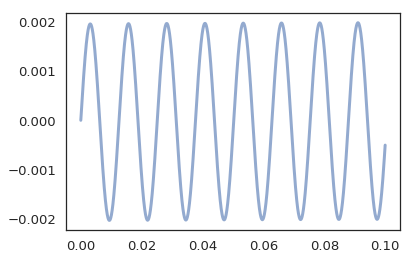

In [181]:
test_sys = make_system(make_params(R=1000, L=0.0047, C=0.0001, F=500))
res = run_odeint(test_sys, slope_func)
#for i in range(len(res)):
#    out.append([i*test_sys.sim_timestep, res['I'][i]])

#out = []
#for i in np.linspace(0, 0.1, 500):
#    out.append([i, np.sin(i*500)])
#out = np.asarray(out)/10
#plot(out, '--')
plot(res['I'][0:0.1]*test_sys.R, '-')

As we can see, the output of this system is (similarly) a sin wave, showing its validity as an analog filter.

III. Defining the transfer function of the circuit. 

We found that the differential equations of this circuit required too high of a simulation fidelity to simulate accurately at high frequencies. We decided to transform the time-based differential equations into a frequency-based transfer function, which the python-control library would allow us to manipulate much faster and more accurately than could be done with a differential equation-based simulation.

Generalized transfer function of a series RLC circuit: 

$\frac{V_o}{V_i}=\frac{R}{L} \frac{s}{s^2 + \frac{R}{L} + \frac{1}{LC}}$.

By seperating the coefficients of ω, the equation is more explicitly shown. The "top" and "bottom" in the following section presents the numerator and denominators of the transfer function. 


In [182]:
top = np.asarray([1, 0])*R
bottom = np.asarray([1, R/L, 1/(L*C)])*L
sys_tf = cntrl.tf(top, bottom)


          1000 s
---------------------------
0.0047 s^2 + 1000 s + 1e+04

In [183]:
def make_tf(params):
    R = params.R
    L = params.L
    C = params.C
    top = np.asarray([1, 0])*R
    bottom = np.asarray([1, R/L, 1/(L*C)])*L
    return cntrl.tf(top, bottom)

IV. Defining step functions

In order to simulate the system against an arbitrary time signal, we need to transform it into a state-space representation, in the form

$\frac{d}{dt} x = \mathbf{A}x + \mathbf{B}u$

or, in discrete-time form

$x_{t+1} = \mathbf{A_c}x_t + \mathbf{B_c}u$


In [187]:
def make_ss(sys_tf, dt=None):
    if dt is None:
        return cntrl.ss(sys_tf)
    return cntrl.c2d(cntrl.ss(sys_tf), dt)


In [188]:
sys_tf = make_tf(make_params(R=1000, L=0.0047, C=0.0001, F=1))


          1000 s
---------------------------
0.0047 s^2 + 1000 s + 1e+04

In [201]:
sys_ss_c = make_ss(sys_tf, 0.0001)

A = [[-4.69590671e-05 -9.99094372e+00]
 [ 4.69574355e-06  9.99047413e-01]]

B = [[4.69574355e-06]
 [4.47716116e-10]]

C = [[212765.95744681      0.        ]]

D = [[0.]]

dt = 0.0001

Now, we can write a simple simulation function to test by passing a sine wave at 8 rad/s through the discretized state space model

In [218]:
def lsim(sys, vec):
    state = np.zeros((sys.A.shape[0], 1))
    dt = sys.dt
    t = []
    y = []
    for i in range(len(vec)):
        state = np.matmul(sys.A, state) + sys.B*vec[i]
        output = np.matmul(sys.C, state)
        t.append(i*dt)
        y.append(float(output))
    return t,y
sin_x = np.linspace(0, 8*np.pi, int(1/sys_ss_c.dt))
sin_y = np.sin(sin_x)
t, y = lsim(sys_ss_c, sin_y)
sin_x /= 8*np.pi

array([0.00000000e+00, 1.00010001e-04, 2.00020002e-04, ...,
       9.99799980e-01, 9.99899990e-01, 1.00000000e+00])

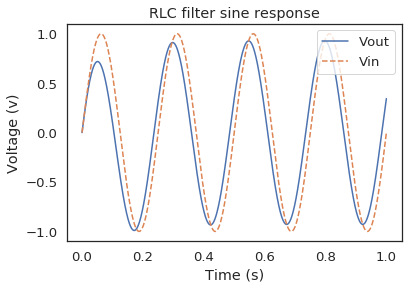

In [219]:
plt.plot(t, y)
plt.plot(sin_x, sin_y, '--')
plt.xlabel("Time (s)")
plt.ylabel("Voltage (v)")
plt.title("RLC filter sine response")
plt.legend(["Vout", "Vin"], loc=1)
plt.show()

To generate a bode (frequency response) plot, we pass in a range of complex numbers representing frequencies, then plot the imaginary part.

In [264]:
#plt.semilogy(np.imag(sys_tf(np.logspace(-3, 3, 1000)*1j)))

def gen_bode(sys_tf, min_exp=-3, max_exp=3, points=1000):
    space = np.logspace(min_exp, max_exp, points)*1j
    data = sys_tf(space)
    out = []
    for i in np.logspace(min_exp, max_exp, points):
        out.append([i, np.imag(sys_tf(i*1j))])
    X = [n[0] for n in out]
    Y = [n[1] for n in out]
    return X, Y

def plot_bode(bode_out):
    X, Y = bode_out
    plt.loglog(X, Y)


As an example, we can plot a filter's response where R=1000, L=0.0047, and C=0.0001

Text(0,0.5,'Gain')

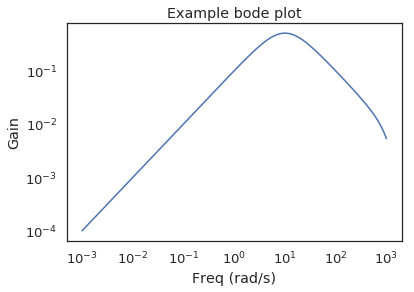

In [286]:
plot_bode(
    gen_bode(
        make_tf(
            make_params(
                R=1000, L=0.0047, C=.0001, F=1
            )
        )
    )
)
plt.title("Example bode plot")
plt.xlabel("Freq (rad/s)")
plt.ylabel("Gain")

To actually analyze the system, we need to know the peak freqency and the frequency range in which the gain is greater than -3dB, equal to $\frac{\sqrt{2}}{2}$

In [285]:
def analyze_bode(plot):
    X, Y = plot
    bw_start = None
    bw_end = None
    peak = X[np.argmax(Y)]
    peak_filt = np.max(Y)
    for i in range(len(Y)-1):
        if (Y[i] > (np.sqrt(2)/2)*peak_filt) and bw_start is None:
            bw_start = X[i]
        if (Y[i] < (np.sqrt(2)/2)*peak_filt) and bw_end is None and bw_start is not None:
            bw_end = X[i]
            
    return peak, bw_end-bw_start


(0.99310918137498, 2.0244407637876627)


As an example, we'll find the bandpass and bandwidth for the filter represented by the above bode plot

In [293]:

bpass, bwidth = analyze_bode(
        gen_bode(
        make_tf(
            make_params(
                R=1000, L=0.0047, C=0.001, F=1
            )
        )
    )
)
print("Bandpass frequency:",bpass, "rad/s \nBandwidth frequency:", bwidth, "rad/s")

Bandpass frequency: 0.99310918137498 rad/s 
Bandwidth frequency: 2.0244407637876627 rad/s


Now, we will sweep a range of values for R, L, and C in order to find the values for our filter to best match our design parameters (passband frequency of 40 rad/s, and a bandwidth of 5 rad/s)

In [ ]:
fs = [1, 10, 100, 1000, 10000, 100000]

def sweep_freq():
    ratios = TimeSeries()
    offsets = TimeSeries()
    
    for i, f in enumerate(fs):
        system = make_system(Params(params, f=f))
        series = compute_vin(results, system)
        V = estimate_A(series)
        A_in = estimate_A(V_in)
        A_out = estimate_A(V_out)

        ratios = A_out / A_in
        offsets = compute_offset(corr)


    return ratios, offsets


In [ ]:
def sweep_frequency(fs, params):
    ratios = SweepSeries()
    offsets = SweepSeries()

    for i, f in enumerate(fs):
        system = make_system(Params(params, f=f))
        results, details = run_ode_solver(system, slope_func, t_eval=system.ts)
        V_out = results.V_out
        V_in = compute_vin(results, system)
        ratios[f] = estimate_ratio(V_out, V_in)
        offsets[f] = estimate_offset(V_out, V_in, system)
    return ratios, offsets

fs = 10 ** linspace(0, 4, 9)
ratios, offsets = sweep_frequency(fs, params)

In [ ]:
def plot_ratios(ratios, system):
    """Plot output ratios.
    """
    plt.axvline(system.cutoff, color='gray', alpha=0.4)
    plot(ratios, color='C2', label='output ratio')
    decorate(xlabel='Frequency (Hz)',
             ylabel='$V_{out} / V_{in}$',
             xscale='log', yscale='log')

In [ ]:
plot_ratios(ratios, system)

In [ ]:
def plot_offsets(offsets, system):
    """Plot phase offsets.
    """
    plt.axvline(system.cutoff, color='gray', alpha=0.4)
    plot(offsets, color='C9')
    decorate(xlabel='Frequency (Hz)',
             ylabel='Phase offset (degree)',
             xscale='log')

In [ ]:
plot_offsets(offsets, system)